
# <center> Syracuse University </center>
 
 
 
 



 
 
 
# <center> IST-664 HW#1 Comparing Corpora with Corpus Statistics. </center>

 
 
 
 
 
 
 

 
ThulasiRam RuppaKrishnan

IST 664

Professor Michael Larche


## 1.  Choosing the data

### State of the Union Corpus (1790 - 2018)
### Full text of the State of the Union address between 1790 and 2018

### Introduction
The State of the Union is an annual address by the President of the United States before a joint session of congress. In it, the President reviews the previous year and lays out his legislative agenda for the coming year.

### About the Data
This dataset contains the full text of the State of the Union address from 1989 (Regan) to 2017 (Trump).

In [1]:
## Import Libraries for data wrangling and visualization
import os
import math
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import requests

## Import NLTK required modules for this project
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## For Stemming
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
ps =PorterStemmer()
lem=WordNetLemmatizer()


In [2]:
# Variable Declaration begins here
path="C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\HW1\\state-of-the-union-corpus-1989-2017"
buzzwords_path="C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\HW1\\buzzwords"
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/v/o/v/j/p/S/70-hi.png', stream=True).raw))
mask_pos = np.array(Image.open('C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 736\\Week4\\positive.JPG'))
mask_neg = np.array(Image.open('C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 736\\Week4\\negative.JPG'))
mask_neu = np.array(Image.open('C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST 736\\Week4\\neutral.JPG'))
# Variable Decalration ends here

### Text processing options 
a)	Briefly state why you chose the processing options that you did.

        The code is modularised to perform task for reading the text from the corpus, cleaning and to apply required transformation for this analysis. Filter is applied to extract the text from the speakers 'Bush-Sr','Bush','Clinton','Obama','Trump'.
        
b)	Are there any problems with the word or bigram lists that you found? Could you get a better list of bigrams? 

        Some of the bigrams and Trigrams had stopwords, verb forms and other punctuation characters. To get a better list of bigrams and Trigrams, word filters to remove stop words, verb forms and other non alphabetic characters are applied.

c)	How are the top 50 bigrams by frequency different from the top 50 bigrams scored by Mutual Information?

    Top 50 Bigrams and Trigrams using mutual information is more precise than by frequency.

d)	If you modify the stop word list, or expand the methods of filtering, describe that here.

        Additional stop words such as (. , i ' and - : ; - -- ve we the $) are added to the base stop word list from Smart.English.stop to filter noise which are not required for sentiment analysis and to facilitate text comparison in the areas of Domestic Policy, Economy, Foreign Policy, Framing and Process discussed in part 3

e)	You may choose to also run top trigram lists, and include them in the analysis in part 3.

        Trigrams are also generated used by speakers 'Bush-Sr','Bush','Clinton','Obama','Trump'

In [3]:
# Function Definitions begins here
def search_files(directory='.', extension=''):
    extension = extension.lower()
    file_path=[]
    file_name=[]
    for dirpath, dirnames, files in os.walk(directory):
        for name in files:
            if extension and name.lower().endswith(extension):
                file_path.append(os.path.join(dirpath, name))
                file_name.append(os.path.join(name))
            elif not extension:
                file_path.append(os.path.join(dirpath, name))
                file_name.append(os.path.join(name))
    return [file_path,file_name]

def get_files_frm_path(path):
    ListOfCompleteFilePaths=[]
    ListOfJustFileNames=[]
    for name in os.listdir(path):
        print(path+ "\\" + name)
        next=path+ "\\" + name
        nextnameL=name.split(".")
        nextname=nextnameL[0]
        ListOfCompleteFilePaths.append(next)
        ListOfJustFileNames.append(nextname)
    return [ListOfCompleteFilePaths,ListOfJustFileNames]

# Python3 program to convert a list 
# of integers into a single integer 
def convert(list): 
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    # Join list items using join() 
    res = ("".join(s)) 
    return(res) 

def alpha_filter(w):
  # pattern to match word of non-alphabetical characters
  pattern = re.compile('^[^a-z]+$')
  if (pattern.match(w)):
    return True
  else:
    return False

def verb_forms_filter(w):
  # pattern to match word of non-alphabetical characters
  #pattern = re.compile('\b(?!\w+(ing|ed)\b)\S+')
  pattern = re.compile('^\w+(?:ing|ed)$')
  if (pattern.match(w)):
    return True
  else:
    return False

def create_corpus_df_frm_corpus_doc(path,cat_pattern=r'*.txt'):
    # Read corpus of document into dataframe
    # https://stackoverflow.com/questions/49088978/how-to-create-corpus-from-pandas-data-frame-to-operate-with-nltk
    my_corpus=CategorizedPlaintextCorpusReader(path,r'.*', cat_pattern=r'*.txt') 
    my_corpus.fileids() # <- I expect values from column ID
#    #my_corpus.categories() # <- I don't have a category defined in this case
#    my_corpus.words(fileids='Reagan_1982.txt') # <- I expect values from column TITLE and BODY
#    my_corpus.sents(fileids=['Reagan_1982.txt', 'Truman_1949.txt']) # <- I expect values from column TITLE and BODY
#    
    ListOffiles= pd.DataFrame(my_corpus.fileids(),columns=['file_nm'])
    
    bow,doc=[],[]
    for index in range(len(ListOffiles)-1):
        print(index,ListOffiles['file_nm'][index])
        doc.append(ListOffiles['file_nm'][index])
        my_list = my_corpus.words(fileids=ListOffiles['file_nm'][index])[:]
        bow.append(list(my_list))
    
    corpus_df=pd.DataFrame()
    corpus_df['doc'] =doc
    corpus_df['bow'] =bow
    return corpus_df

def convert_lcase_rm_stopw(corpus_df,stopw_file_path='C:\\Users\\rkrishnan\\Documents\\01 Personal\\MS\\IST664\\Week3\\Smart.English.stop'):
    # convert to lower case and remove stop words
    fstop = open(stopw_file_path, 'r')
    stoptext = fstop.read()
    fstop.close()
    
    stopwords = nltk.word_tokenize(stoptext)
    print ("Display first 50 Stopwords:")
    print (stopwords[:50])
    corpus_df_lcase=corpus_df.copy(deep=True)
    corpus_df_rm_sw=corpus_df.copy(deep=True)
    corpus_df_rm_sw['bow'] = corpus_df['bow'].apply(lambda x: list(y.lower() for y in x if y not in stopwords))
    corpus_df_lcase['bow'] = corpus_df['bow'].apply(lambda x: list(y.lower() for y in x))
    corpus_df['bow'].head()

    return corpus_df_lcase,stopwords,corpus_df_rm_sw

def compare_porter_lancaster_stems(filewords,porter_stem_words,lancaster_stem_words):
    result=[]
    result_dict={}
    for idx,w in enumerate(filewords):
        if w!=porter_stem_words[idx] and w!=lancaster_stem_words[idx] and porter_stem_words[idx]==lancaster_stem_words[idx]:
            result.append("Stemming is same in porter and lancaster")
        elif w!=porter_stem_words[idx] and w!=lancaster_stem_words[idx] and porter_stem_words[idx]!=lancaster_stem_words[idx]:
            result.append("Stemming is different in porter and lancaster")
        elif w==porter_stem_words[idx] and w==lancaster_stem_words[idx]:
            result.append("No stemming on both porter and lancaster")
        elif w==porter_stem_words[idx] and w!=lancaster_stem_words[idx]:
            result.append("Stemmed on lancaster but not on porter")
        elif w!=porter_stem_words[idx] and w==lancaster_stem_words[idx]:
            result.append("Stemmed on porter but not on lancaster")
        else:
            result.append("No result")
    result_dict={'filewords':filewords,'porter_stem_words':porter_stem_words,'lancaster_stem_words':lancaster_stem_words,'result':result}
    return result,result_dict
  
# Function Definitions ends here

In [4]:
print("calling os...")
## Print the files in this location to make sure I am where I want to be
print(os.listdir(path))
file_path,file_name=search_files(path,'.txt')
buzz_file_path,buzz_file_name=search_files(buzzwords_path,'.txt')


corpus_df=create_corpus_df_frm_corpus_doc(path)
corpus_df_lcase,stopwords,corpus_df=convert_lcase_rm_stopw(corpus_df)


calling os...
['Adams_1797.txt', 'Adams_1798.txt', 'Adams_1799.txt', 'Adams_1800.txt', 'Adams_1825.txt', 'Adams_1826.txt', 'Adams_1827.txt', 'Adams_1828.txt', 'Arthur_1881.txt', 'Arthur_1882.txt', 'Arthur_1883.txt', 'Arthur_1884.txt', 'Buchanan_1857.txt', 'Buchanan_1858.txt', 'Buchanan_1859.txt', 'Buchanan_1860.txt', 'Buren_1837.txt', 'Buren_1838.txt', 'Buren_1839.txt', 'Buren_1840.txt', 'Bush_1989.txt', 'Bush_1990.txt', 'Bush_1991.txt', 'Bush_1992.txt', 'Bush_2001.txt', 'Bush_2002.txt', 'Bush_2003.txt', 'Bush_2004.txt', 'Bush_2005.txt', 'Bush_2006.txt', 'Bush_2007.txt', 'Bush_2008.txt', 'Carter_1978.txt', 'Carter_1979.txt', 'Carter_1980.txt', 'Carter_1981.txt', 'Cleveland_1885.txt', 'Cleveland_1886.txt', 'Cleveland_1887.txt', 'Cleveland_1888.txt', 'Cleveland_1893.txt', 'Cleveland_1894.txt', 'Cleveland_1895.txt', 'Cleveland_1896.txt', 'Clinton_1993.txt', 'Clinton_1994.txt', 'Clinton_1995.txt', 'Clinton_1996.txt', 'Clinton_1997.txt', 'Clinton_1998.txt', 'Clinton_1999.txt', 'Clinton_2000

188 Roosevelt_1940.txt
189 Roosevelt_1941.txt
190 Roosevelt_1942.txt
191 Roosevelt_1943.txt
192 Roosevelt_1944.txt
193 Roosevelt_1945.txt
194 Taft_1909.txt
195 Taft_1910.txt
196 Taft_1911.txt
197 Taft_1912.txt
198 Taylor_1849.txt
199 Truman_1946.txt
200 Truman_1947.txt
201 Truman_1948.txt
202 Truman_1949.txt
203 Truman_1950.txt
204 Truman_1951.txt
205 Truman_1952.txt
206 Truman_1953.txt
207 Trump_2017.txt
208 Trump_2018.txt
209 Tyler_1841.txt
210 Tyler_1842.txt
211 Tyler_1843.txt
212 Tyler_1844.txt
213 Washington_1790.txt
214 Washington_1791.txt
215 Washington_1792.txt
216 Washington_1793.txt
217 Washington_1794.txt
218 Washington_1795.txt
219 Washington_1796.txt
220 Wilson_1913.txt
221 Wilson_1914.txt
222 Wilson_1915.txt
223 Wilson_1916.txt
224 Wilson_1917.txt
225 Wilson_1918.txt
226 Wilson_1919.txt
Display first 50 Stopwords:
['â€™s', 'a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'all

In [5]:
buzzwords_df=create_corpus_df_frm_corpus_doc(buzzwords_path)
buzzwords_df_lcase,stopwords,buzzwords_df=convert_lcase_rm_stopw(buzzwords_df)

0 DomesticPolicy.txt
1 Economy.txt
2 ForeignPolicy.txt
3 Framing.txt
4 Process.txt
Display first 50 Stopwords:
['â€™s', 'a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking']


In [6]:
buzzwords_df_lcase['AOfInterest']=buzzwords_df_lcase['doc'].apply(lambda x: str(((x).split('.')[0])))

In [7]:
for speech in corpus_df.iterrows():
    buzzwords_df_lcase[speech[1][0].split('.')[0]]=0
    
for speech in corpus_df.iterrows():
    buzzwords_df_lcase[speech[1][0].split('.')[0]]=0
    for word in speech[1][1]:
        for item in buzzwords_df_lcase.iterrows():
            if  word in item[1][1]:
                buzzwords_df_lcase.loc[item[0],speech[1][0].split('.')[0]]+=1

In [8]:
corpus_df.head()

doc                                                bow
0  Adams_1797.txt  [gentlemen, senate, gentlemen, house, represen...
1  Adams_1798.txt  [gentlemen, senate, gentlemen, house, represen...
2  Adams_1799.txt  [gentlemen, senate, gentlemen, house, represen...
3  Adams_1800.txt  [gentlemen, senate, gentlemen, house, represen...
4  Adams_1825.txt  [fellow, citizens, senate, house, representati...

In [9]:
corpus_df['president']=corpus_df['doc'].apply(lambda x: str(((x).split('.')[0].split('_')[0])))
corpus_df['year']=corpus_df['doc'].apply(lambda x: int(((x).split('.')[0].split('_')[1])))
corpus_df.loc[(corpus_df.president == 'Bush') & (corpus_df.year<2001),'president']='Bush-Sr'

corpus_df.head()

doc                                                bow  \
0  Adams_1797.txt  [gentlemen, senate, gentlemen, house, represen...   
1  Adams_1798.txt  [gentlemen, senate, gentlemen, house, represen...   
2  Adams_1799.txt  [gentlemen, senate, gentlemen, house, represen...   
3  Adams_1800.txt  [gentlemen, senate, gentlemen, house, represen...   
4  Adams_1825.txt  [fellow, citizens, senate, house, representati...   

  president  year  
0     Adams  1797  
1     Adams  1798  
2     Adams  1799  
3     Adams  1800  
4     Adams  1825

In [10]:
filter=['Bush-Sr','Bush','Clinton','Obama','Trump']
corpus_df_filtered=corpus_df.loc[(corpus_df.president == 'Bush-Sr') | (corpus_df.president == 'Bush')| (corpus_df.president == 'Clinton')| (corpus_df.president == 'Obama')| (corpus_df.president == 'Trump')]

In [11]:
corpus_df_filtered

doc                                                bow  \
20      Bush_1989.txt  [mr, speaker, mr, president, distinguished, me...   
21      Bush_1990.txt  [tonight, i, speak, ", state, government, ",, ...   
22      Bush_1991.txt  [mr, president, mr, speaker, members, united, ...   
23      Bush_1992.txt  [mr, speaker, mr, president, distinguished, me...   
24      Bush_2001.txt  [to, congress, united, states, mr, speaker, mr...   
25      Bush_2002.txt  [thank, mr, speaker, vice, president, cheney, ...   
26      Bush_2003.txt  [mr, speaker, vice, president, cheney, members...   
27      Bush_2004.txt  [mr, speaker, vice, president, cheney, members...   
28      Bush_2005.txt  [mr, speaker, vice, president, cheney, members...   
29      Bush_2006.txt  [mr, speaker, vice, president, cheney, members...   
30      Bush_2007.txt  [to, the, congress, of, the, united, states, t...   
31      Bush_2008.txt  [madam, speaker, vice, president, cheney, memb...   
44   Clinton_1993.txt  [mr, president, mr, speaker, members, house, s...   
45   Clinton_1994.txt  [mr, speaker, mr, president, members, 103rd, c...   
46   Clinton_1995.txt  [mr, president, mr, speaker, members, 104th, c...   
47   Clinton_1996.txt  [mr, speaker, mr, vice, president, members, 10...   
48   Clinton_1997.txt  [mr, speaker, mr, vice, president, members, 10...   
49   Clinton_1998.txt  [mr, speaker, mr, vice, president, members, 10...   
50   Clinton_1999.txt  [mr, speaker, mr, vice, president, members, co...   
51   Clinton_2000.txt  [mr, speaker, mr, vice, president, members, co...   
151    Obama_2009.txt  [madame, speaker, mr, vice, president, members...   
152    Obama_2010.txt  [madame, speaker, vice, president, biden, memb...   
153    Obama_2011.txt  [mr, speaker, mr, vice, president, members, co...   
154    Obama_2012.txt  [mr, speaker, mr, vice, president, members, co...   
155    Obama_2013.txt  [mr, speaker, mr, vice, president, members, co...   
156    Obama_2014.txt  [mr, speaker, mr, vice, president, members, co...   
157    Obama_2015.txt  [mr, speaker, mr, vice, president, members, co...   
158    Obama_2016.txt  [mr, speaker, mr, vice, president, members, co...   
207    Trump_2017.txt  [thank, mr, speaker, mr, vice, president, memb...   
208    Trump_2018.txt  [mr, speaker, mr, vice, president, members, co...   

    president  year  
20    Bush-Sr  1989  
21    Bush-Sr  1990  
22    Bush-Sr  1991  
23    Bush-Sr  1992  
24       Bush  2001  
25       Bush  2002  
26       Bush  2003  
27       Bush  2004  
28       Bush  2005  
29       Bush  2006  
30       Bush  2007  
31       Bush  2008  
44    Clinton  1993  
45    Clinton  1994  
46    Clinton  1995  
47    Clinton  1996  
48    Clinton  1997  
49    Clinton  1998  
50    Clinton  1999  
51    Clinton  2000  
151     Obama  2009  
152     Obama  2010  
153     Obama  2011  
154     Obama  2012  
155     Obama  2013  
156     Obama  2014  
157     Obama  2015  
158     Obama  2016  
207     Trump  2017  
208     Trump  2018

## 2.  Examine the text in the documents 

### Top 50 words by frequency used by 'Bush-Sr','Bush','Clinton','Obama','Trump'

In [12]:
for speaker in filter:
    temp_df=corpus_df_filtered[corpus_df_filtered.president==speaker]
    dist = FreqDist(nltk.flatten(list(temp_df['bow'])))
    mc = dist.most_common(50)
    print('Most common 50 words spoken by {} :'.format(speaker))
    for word in mc:
      print(word)
    print('*'*100)

Most common 50 words spoken by Bush-Sr :
('i', 254)
('and', 233)
('we', 123)
('america', 91)
('world', 81)
('people', 63)
('the', 61)
('american', 60)
('but', 53)
('time', 51)
('tonight', 50)
('future', 48)
('it', 41)
('nation', 40)
('make', 40)
('year', 40)
('budget', 38)
('"', 38)
('plan', 37)
('work', 32)
('congress', 32)
('freedom', 32)
('government', 29)
('this', 28)
('free', 27)
('americans', 26)
('home', 25)
('growth', 25)
('country', 25)
('federal', 24)
('economic', 23)
('children', 23)
('years', 22)
('billion', 22)
('tax', 22)
('power', 22)
('long', 22)
('ago', 21)
('hope', 21)
('today', 21)
('our', 21)
('a', 21)
('great', 20)
('put', 20)
('they', 20)
('health', 20)
('peace', 19)
('give', 19)
('war', 19)
('my', 19)
****************************************************************************************************
Most common 50 words spoken by Bush :
('i', 284)
('we', 263)
('america', 232)
('and', 202)
('people', 169)
('the', 153)
('world', 124)
('country', 113)
('security', 

### Top 50 Trigrams by frequencies used by 'Bush-Sr','Bush','Clinton','Obama','Trump'

In [13]:

for speaker in filter:
    temp_df=corpus_df_filtered[corpus_df_filtered.president==speaker]            
    #trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder3 = TrigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))     
    # choose to use both the non-alpha word filter and a stopwords filter
    finder3.apply_word_filter(alpha_filter)
    finder3.apply_word_filter(verb_forms_filter)
    finder3.apply_word_filter(lambda w: w in stopwords)
    #finder3.apply_freq_filter(5)

    # score by frequency and display the top 50 bigrams
    tri_gram_score_freq = finder3.score_ngrams(TrigramAssocMeasures.raw_freq)
    print ()
    print('Trigrams from file with top 50 frequencies spoken by {} :'.format(speaker))
    for item in tri_gram_score_freq[:50]:
            print (item)
    print('*'*100)


Trigrams from file with top 50 frequencies spoken by Bush-Sr :
(('hard', 'work', 'freedom'), 0.000585411544315654)
(('capital', 'gains', 'tax'), 0.00035124692658939234)
(('cut', 'capital', 'gains'), 0.00035124692658939234)
(('health', 'care', 'system'), 0.00035124692658939234)
(('state', 'union', 'depends'), 0.00035124692658939234)
(('agreement', 'enterprise', 'americas'), 0.00023416461772626156)
(('basic', 'health', 'insurance'), 0.00023416461772626156)
(('brave', 'men', 'women'), 0.00023416461772626156)
(('cabinet', 'departments', 'federal'), 0.00023416461772626156)
(('democracy', 'economic', 'opportunity'), 0.00023416461772626156)
(('departments', 'federal', 'agencies'), 0.00023416461772626156)
(('enterprise', 'americas', 'initiative'), 0.00023416461772626156)
(('environmental', 'protection', 'agency'), 0.00023416461772626156)
(('free', 'trade', 'agreement'), 0.00023416461772626156)
(('fulfill', 'long', 'held'), 0.00023416461772626156)
(('governors', 'line', 'item'), 0.000234164617


Trigrams from file with top 50 frequencies spoken by Obama :
(('small', 'business', 'owners'), 0.0003102218085931441)
(('bless', 'god', 'bless'), 0.0002714440825190011)
(('cost', 'health', 'care'), 0.0002714440825190011)
(('god', 'bless', 'god'), 0.0002714440825190011)
(('mr', 'vice', 'president'), 0.0002714440825190011)
(('president', 'members', 'congress'), 0.0002714440825190011)
(('speaker', 'mr', 'vice'), 0.0002714440825190011)
(('vice', 'president', 'members'), 0.0002714440825190011)
(('health', 'care', 'reform'), 0.00023266635644485808)
(('high', 'school', 'diploma'), 0.00023266635644485808)
(('mr', 'speaker', 'mr'), 0.00023266635644485808)
(('vice', 'president', 'biden'), 0.00023266635644485808)
(('america', 'mr', 'speaker'), 0.00019388863037071507)
(('men', 'women', 'uniform'), 0.00019388863037071507)
(('middle', 'class', 'economics'), 0.00019388863037071507)
(('middle', 'class', 'families'), 0.00019388863037071507)
(('ship', 'jobs', 'overseas'), 0.00019388863037071507)
(('sma

### Top 50 Trigrams by their Mutual Information scores (using min frequency 5)

In [14]:
for speaker in filter:
    temp_df=corpus_df_filtered[corpus_df_filtered.president==speaker]            
    #trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder3 = TrigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))     
    # choose to use both the non-alpha word filter and a stopwords filter
    finder3.apply_word_filter(alpha_filter)
    finder3.apply_word_filter(verb_forms_filter)
    finder3.apply_word_filter(lambda w: w in stopwords)
    finder3.apply_freq_filter(5)
    
    # score by PMI and display the top 50 trigrams
    # only use frequently occurring words in mutual information
    tri_gram_score_pmi = finder3.score_ngrams(TrigramAssocMeasures.pmi)
    print ('\nTrigrams from file with top 50 mutual information scores by {} :'.format(speaker))
    for item in tri_gram_score_pmi[:50]:
            print (item)
    print('*'*100)


Trigrams from file with top 50 mutual information scores by Bush-Sr :
(('hard', 'work', 'freedom'), 14.98287503317691)
****************************************************************************************************

Trigrams from file with top 50 mutual information scores by Bush :
(('mr', 'speaker', 'vice'), 21.480968394756303)
(('vice', 'president', 'cheney'), 20.85091800450661)
(('speaker', 'vice', 'president'), 20.07331042584306)
(('president', 'cheney', 'members'), 18.61874456237758)
(('weapons', 'mass', 'destruction'), 18.360357277288948)
(('guests', 'fellow', 'citizens'), 17.80361228972825)
(('health', 'savings', 'accounts'), 17.538888370685484)
(('cheney', 'members', 'congress'), 16.632683753335456)
(('america', 'competitive', 'requires'), 15.693376727520127)
(('social', 'security', 'benefits'), 14.446734703551861)
(('social', 'security', 'medicare'), 14.063406064000354)
****************************************************************************************************



### Top 50 bigrams by frequencies used by 'Bush-Sr','Bush','Clinton','Obama','Trump'

In [15]:
for speaker in filter:
    temp_df=corpus_df_filtered[corpus_df_filtered.president==speaker]
    #bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder2 = BigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))
    # choose to use both the non-alpha word filter and a stopwords filter
    finder2.apply_word_filter(alpha_filter)
    finder2.apply_word_filter(verb_forms_filter)
    finder2.apply_word_filter(lambda w: w in stopwords)
    #finder2.apply_freq_filter(5)
    
    # score by frequency and display the top 50 bigrams
    bi_gram_score_freq = finder2.score_ngrams(BigramAssocMeasures.raw_freq)
    print ()
    print('Bigrams from file with top 50 frequencies spoken by {} :'.format(speaker))
    for item in bi_gram_score_freq[:50]:
            print (item)
    print('*'*100)


Bigrams from file with top 50 frequencies spoken by Bush-Sr :
(('american', 'people'), 0.001170823088631308)
(('economic', 'growth'), 0.001053740779768177)
(('long', 'term'), 0.001053740779768177)
(('capital', 'gains'), 0.0009366584709050462)
(('health', 'care'), 0.0009366584709050462)
(('state', 'union'), 0.0009366584709050462)
(('years', 'ago'), 0.0009366584709050462)
(('men', 'women'), 0.0008195761620419155)
(('child', 'care'), 0.0007024938531787847)
(('god', 'bless'), 0.0007024938531787847)
(('states', 'america'), 0.0007024938531787847)
(('tax', 'credit'), 0.0007024938531787847)
(('eastern', 'europe'), 0.000585411544315654)
(('hard', 'work'), 0.000585411544315654)
(('health', 'insurance'), 0.000585411544315654)
(('interest', 'rates'), 0.000585411544315654)
(('social', 'security'), 0.000585411544315654)
(('work', 'freedom'), 0.000585411544315654)
(('year', 'ago'), 0.000585411544315654)
(('america', 'future'), 0.0004683292354525231)
(('america', 'world'), 0.0004683292354525231)
(('a

### Top 50 bigrams by their Mutual Information scores (using min frequency 5)

In [16]:
            
for speaker in filter:
    temp_df=corpus_df_filtered[corpus_df_filtered.president==speaker]
    #bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder2 = BigramCollocationFinder.from_words(nltk.flatten(list(temp_df['bow'])))
    # choose to use both the non-alpha word filter and a stopwords filter
    finder2.apply_word_filter(alpha_filter)
    finder2.apply_word_filter(verb_forms_filter)
    finder2.apply_word_filter(lambda w: w in stopwords)
    finder2.apply_freq_filter(5)
    
    # score by PMI and display the top 50 bigrams
    # only use frequently occurring words in mutual information
    bi_gram_score_pmi = finder2.score_ngrams(BigramAssocMeasures.pmi)
    print ('\nBigrams from file with top 50 mutual information scores by {} :'.format(speaker))
    for item in bi_gram_score_pmi[:50]:
            print (item)
    print('*'*100)


Bigrams from file with top 50 mutual information scores by Bush-Sr :
(('god', 'bless'), 10.060189278463422)
(('interest', 'rates'), 9.574762451293179)
(('eastern', 'europe'), 9.475226777742265)
(('men', 'women'), 9.37569110419135)
(('capital', 'gains'), 9.153298682854903)
(('social', 'security'), 8.709692031379289)
(('health', 'insurance'), 8.475226777742265)
(('tax', 'credit'), 8.378365238489677)
(('long', 'term'), 8.070242943127345)
(('state', 'union'), 7.89026427702111)
(('health', 'care'), 7.490333670132474)
(('child', 'care'), 7.397224265740993)
(('years', 'ago'), 7.208440237047364)
(('economic', 'growth'), 7.062696134073997)
(('hard', 'work'), 6.922685754713488)
(('year', 'ago'), 5.667871855684661)
(('work', 'freedom'), 5.382117373350784)
(('states', 'america'), 4.889429625542295)
(('american', 'people'), 4.497946854242349)
****************************************************************************************************

Bigrams from file with top 50 mutual information scores

## 3. Problem Description
### i. Comparison of speech between 'Bush-Sr','Bush','Clinton','Obama','Trump' in the areas of Domestic Policy, Economy, Foreign Policy, Framing and Process

Buzz words from these areas chosen and the frequency occurence of these words in the speech are noted for 'Bush-Sr','Bush','Clinton','Obama','Trump' 

In [17]:
buzzwords_df_lcase.loc[:,['AOfInterest','bow']+list(corpus_df_filtered['doc'].apply(lambda x: str(((x).split('.')[0]))))]

AOfInterest                                                bow  \
0  DomesticPolicy  [health, energy, environmental, environment, e...   
1         Economy  [job, jobs, economy, business, businesses, tax...   
2   ForeignPolicy  [nuclear, war, wars, peace, peaceful, communis...   
3         Framing  [hope, hopes, hopeful, dream, dreams, change, ...   
4         Process  [congress, reform, reforms, bill, propose, pro...   

   Bush_1989  Bush_1990  Bush_1991  Bush_1992  Bush_2001  Bush_2002  \
0         19         19         12         25         41         14   
1         48         30         36         75         65         52   
2         33         43         52         39         21         65   
3         64         55         71         49         50         41   
4         55         19         31         55         76         29   

   Bush_2003  Bush_2004  ...  Obama_2009  Obama_2010  Obama_2011  Obama_2012  \
0         28         33  ...          49          36          31          40   
1         59         95  ...         123         180         142         186   
2         80         54  ...          23          26          34          37   
3         40         38  ...          67          92          83          67   
4         39         44  ...          54          91          66          61   

   Obama_2013  Obama_2014  Obama_2015  Obama_2016  Trump_2017  Trump_2018  
0          43          25          18          23          22          11  
1         161         167         143          93          71          74  
2          29          44          46          49          41          35  
3          80          82          89          76          49          58  
4          71          64          57          34          35          44  

[5 rows x 32 columns]

In [18]:
df = buzzwords_df_lcase.loc[:,['AOfInterest']+list(corpus_df_filtered['doc'].apply(lambda x: str(((x).split('.')[0]))))]
df.index=df['AOfInterest']
df.iloc[:,1:].style.background_gradient(cmap='Blues')

Based on the inference above it appears that Clinton and Obama's speech focussed more on Economy when compared to Bush and Trump.

### ii. Polarity of speech between 'Bush-Sr','Bush','Clinton','Obama','Trump' 

In [19]:
corpus_df_filtered=corpus_df_filtered.reset_index(drop=True)

In [20]:
corpus_df_filtered['compound']=0.00
corpus_df_filtered['neg']=0.000
corpus_df_filtered['neu']=0.000
corpus_df_filtered['pos']=0.000
sid = SentimentIntensityAnalyzer()
for index,sentence in enumerate(corpus_df_filtered['bow']):
     #print(sentence)
     ss = sid.polarity_scores(' '.join(sentence))
     for k in sorted(ss):
         corpus_df_filtered.loc[index,corpus_df_filtered.columns.isin([k])]=ss[k]
         print('{}: {}: {}, '.format(corpus_df_filtered.loc[index,'doc'],k, ss[k]), end='')
     print()

Bush_1989.txt: compound: 1.0, Bush_1989.txt: neg: 0.125, Bush_1989.txt: neu: 0.55, Bush_1989.txt: pos: 0.326, 
Bush_1990.txt: compound: 1.0, Bush_1990.txt: neg: 0.072, Bush_1990.txt: neu: 0.62, Bush_1990.txt: pos: 0.308, 
Bush_1991.txt: compound: 0.9999, Bush_1991.txt: neg: 0.164, Bush_1991.txt: neu: 0.535, Bush_1991.txt: pos: 0.301, 
Bush_1992.txt: compound: 0.9999, Bush_1992.txt: neg: 0.14, Bush_1992.txt: neu: 0.606, Bush_1992.txt: pos: 0.253, 
Bush_2001.txt: compound: 1.0, Bush_2001.txt: neg: 0.106, Bush_2001.txt: neu: 0.559, Bush_2001.txt: pos: 0.336, 
Bush_2002.txt: compound: 0.9998, Bush_2002.txt: neg: 0.219, Bush_2002.txt: neu: 0.477, Bush_2002.txt: pos: 0.303, 
Bush_2003.txt: compound: -0.996, Bush_2003.txt: neg: 0.191, Bush_2003.txt: neu: 0.622, Bush_2003.txt: pos: 0.187, 
Bush_2004.txt: compound: 0.9998, Bush_2004.txt: neg: 0.169, Bush_2004.txt: neu: 0.58, Bush_2004.txt: pos: 0.251, 
Bush_2005.txt: compound: 0.9999, Bush_2005.txt: neg: 0.15, Bush_2005.txt: neu: 0.542, Bush_20

In [21]:
corpus_df_filtered

doc                                                bow  \
0      Bush_1989.txt  [mr, speaker, mr, president, distinguished, me...   
1      Bush_1990.txt  [tonight, i, speak, ", state, government, ",, ...   
2      Bush_1991.txt  [mr, president, mr, speaker, members, united, ...   
3      Bush_1992.txt  [mr, speaker, mr, president, distinguished, me...   
4      Bush_2001.txt  [to, congress, united, states, mr, speaker, mr...   
5      Bush_2002.txt  [thank, mr, speaker, vice, president, cheney, ...   
6      Bush_2003.txt  [mr, speaker, vice, president, cheney, members...   
7      Bush_2004.txt  [mr, speaker, vice, president, cheney, members...   
8      Bush_2005.txt  [mr, speaker, vice, president, cheney, members...   
9      Bush_2006.txt  [mr, speaker, vice, president, cheney, members...   
10     Bush_2007.txt  [to, the, congress, of, the, united, states, t...   
11     Bush_2008.txt  [madam, speaker, vice, president, cheney, memb...   
12  Clinton_1993.txt  [mr, president, mr, speaker, members, house, s...   
13  Clinton_1994.txt  [mr, speaker, mr, president, members, 103rd, c...   
14  Clinton_1995.txt  [mr, president, mr, speaker, members, 104th, c...   
15  Clinton_1996.txt  [mr, speaker, mr, vice, president, members, 10...   
16  Clinton_1997.txt  [mr, speaker, mr, vice, president, members, 10...   
17  Clinton_1998.txt  [mr, speaker, mr, vice, president, members, 10...   
18  Clinton_1999.txt  [mr, speaker, mr, vice, president, members, co...   
19  Clinton_2000.txt  [mr, speaker, mr, vice, president, members, co...   
20    Obama_2009.txt  [madame, speaker, mr, vice, president, members...   
21    Obama_2010.txt  [madame, speaker, vice, president, biden, memb...   
22    Obama_2011.txt  [mr, speaker, mr, vice, president, members, co...   
23    Obama_2012.txt  [mr, speaker, mr, vice, president, members, co...   
24    Obama_2013.txt  [mr, speaker, mr, vice, president, members, co...   
25    Obama_2014.txt  [mr, speaker, mr, vice, president, members, co...   
26    Obama_2015.txt  [mr, speaker, mr, vice, president, members, co...   
27    Obama_2016.txt  [mr, speaker, mr, vice, president, members, co...   
28    Trump_2017.txt  [thank, mr, speaker, mr, vice, president, memb...   
29    Trump_2018.txt  [mr, speaker, mr, vice, president, members, co...   

   president  year  compound    neg    neu    pos  
0    Bush-Sr  1989    1.0000  0.125  0.550  0.326  
1    Bush-Sr  1990    1.0000  0.072  0.620  0.308  
2    Bush-Sr  1991    0.9999  0.164  0.535  0.301  
3    Bush-Sr  1992    0.9999  0.140  0.606  0.253  
4       Bush  2001    1.0000  0.106  0.559  0.336  
5       Bush  2002    0.9998  0.219  0.477  0.303  
6       Bush  2003   -0.9960  0.191  0.622  0.187  
7       Bush  2004    0.9998  0.169  0.580  0.251  
8       Bush  2005    0.9999  0.150  0.542  0.309  
9       Bush  2006    0.9999  0.202  0.473  0.325  
10      Bush  2007    0.9998  0.202  0.514  0.284  
11      Bush  2008    1.0000  0.159  0.526  0.316  
12   Clinton  1993    1.0000  0.143  0.570  0.287  
13   Clinton  1994    0.9999  0.171  0.569  0.261  
14   Clinton  1995    0.9999  0.160  0.590  0.249  
15   Clinton  1996    0.9999  0.171  0.560  0.269  
16   Clinton  1997    0.9999  0.118  0.632  0.250  
17   Clinton  1998    1.0000  0.119  0.598  0.283  
18   Clinton  1999    1.0000  0.120  0.585  0.295  
19   Clinton  2000    1.0000  0.135  0.571  0.293  
20     Obama  2009    0.9998  0.173  0.570  0.257  
21     Obama  2010    0.9998  0.182  0.566  0.253  
22     Obama  2011    1.0000  0.108  0.633  0.259  
23     Obama  2012    0.9999  0.138  0.620  0.241  
24     Obama  2013    1.0000  0.132  0.593  0.275  
25     Obama  2014    1.0000  0.132  0.606  0.262  
26     Obama  2015    1.0000  0.143  0.587  0.269  
27     Obama  2016    0.9999  0.176  0.556  0.268  
28     Trump  2017    1.0000  0.156  0.523  0.321  
29     Trump  2018    0.9999  0.183  0.553  0.264

In [22]:
corpus_df_filtered.iloc[:,2:].style.background_gradient(cmap='Blues')

### iii. WordCloud and Sentiment Intensity between 'Bush-Sr','Bush','Clinton','Obama','Trump'

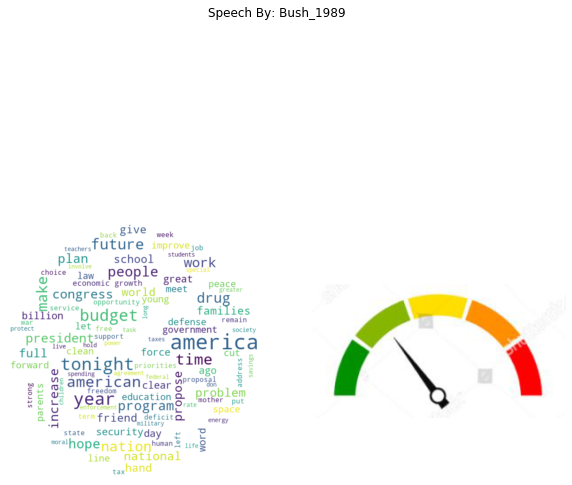

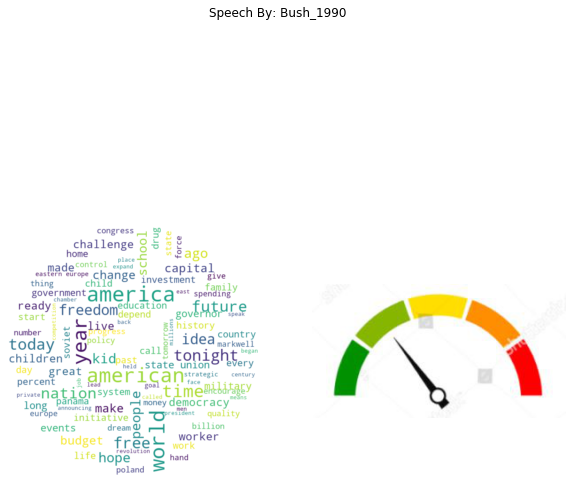

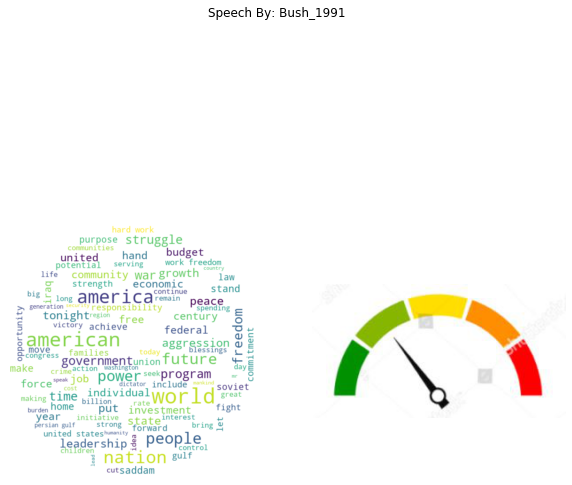

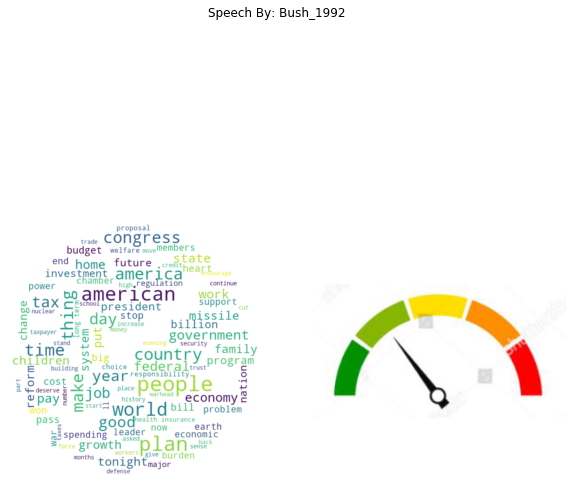

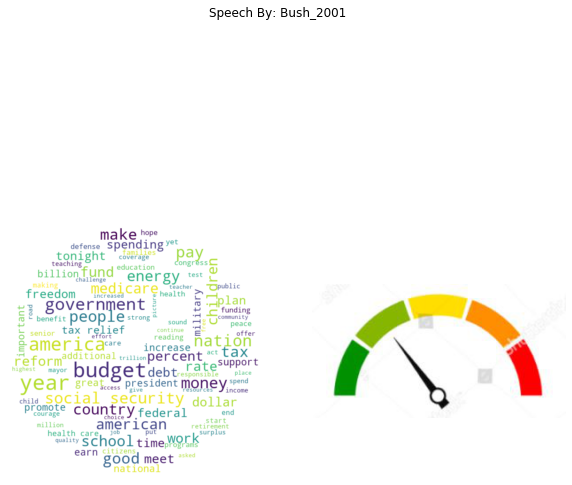

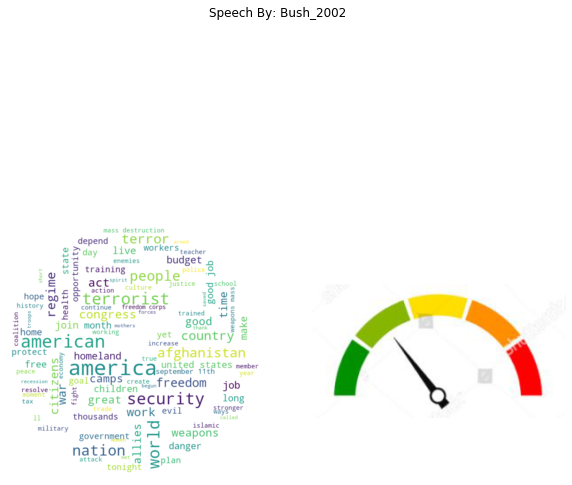

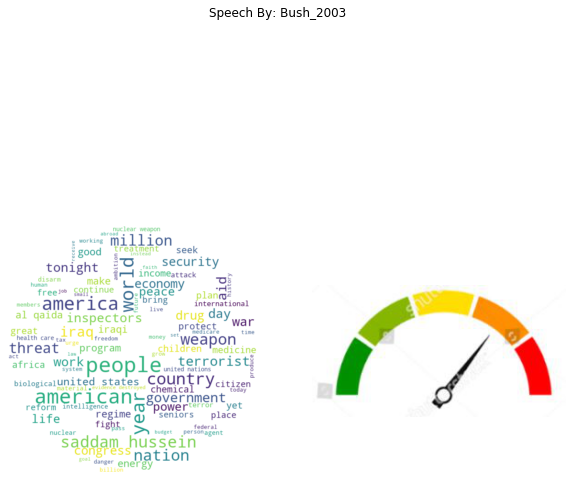

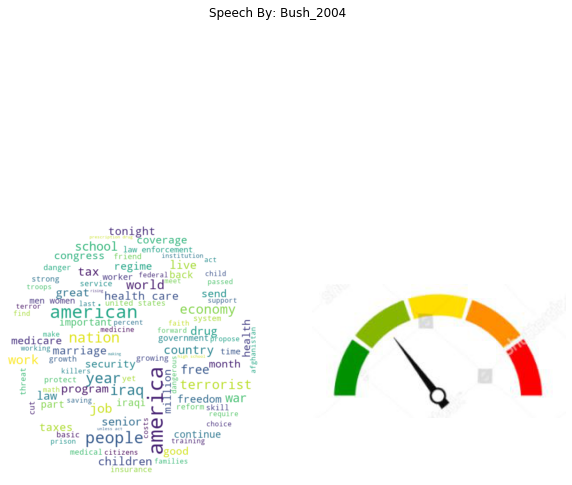

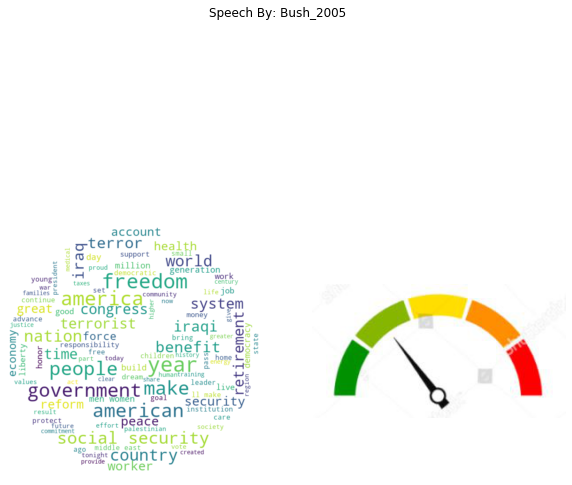

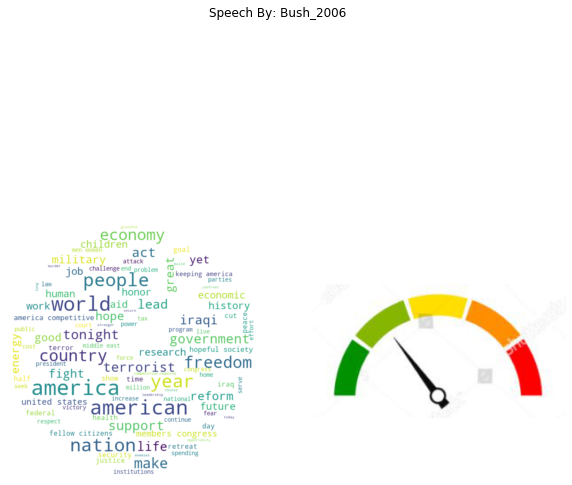

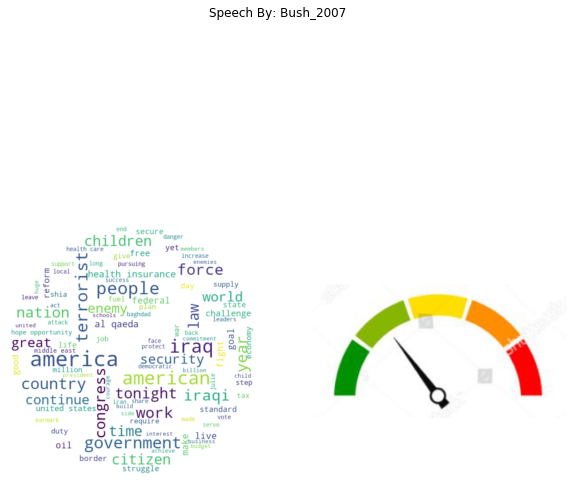

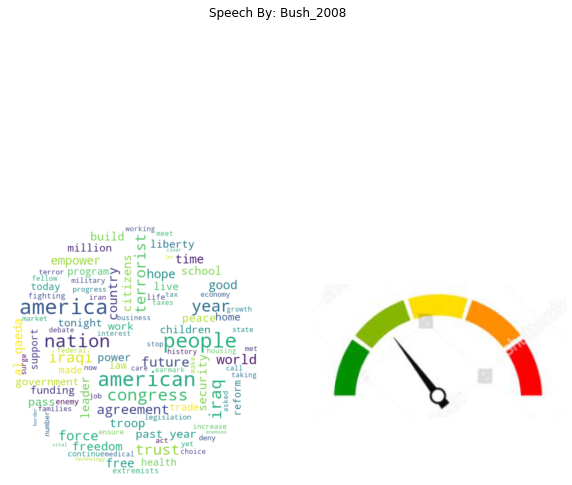

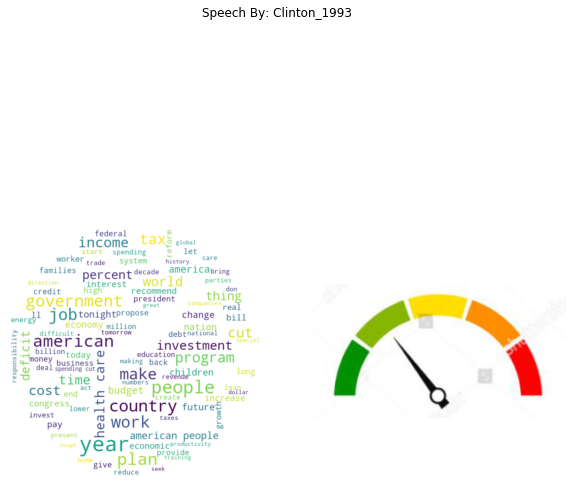

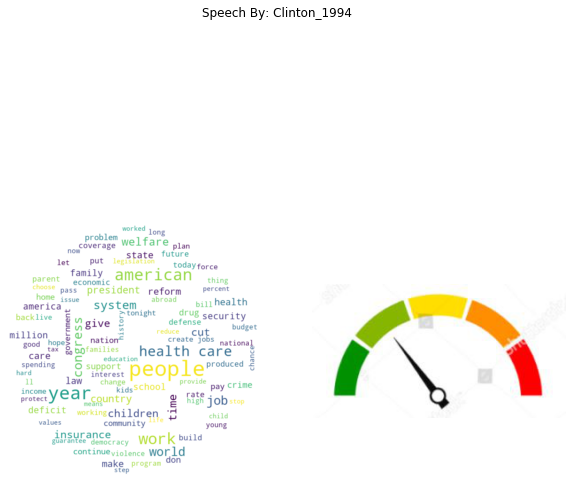

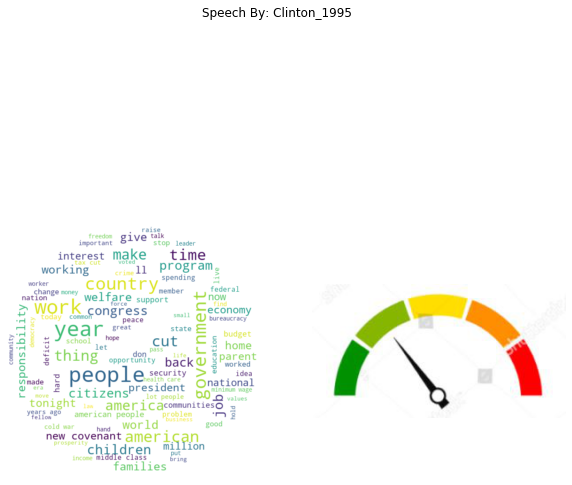

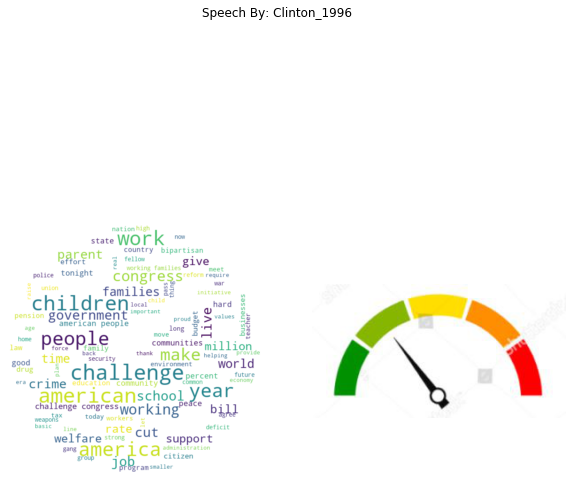

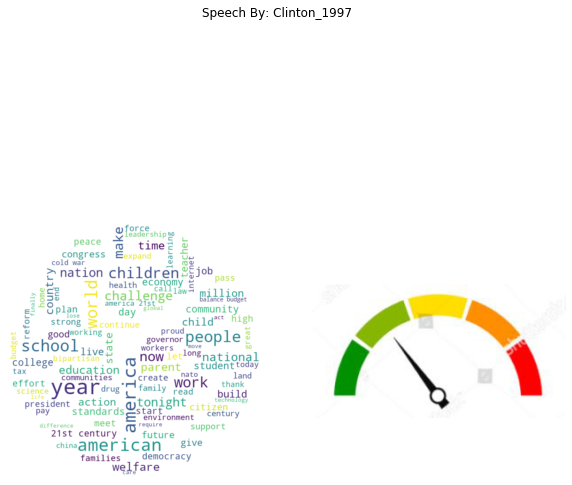

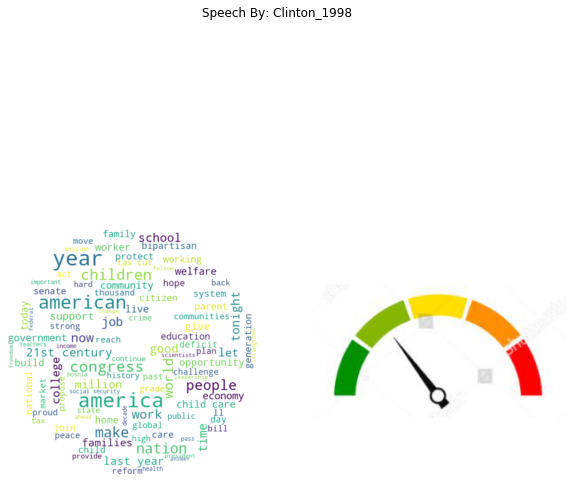

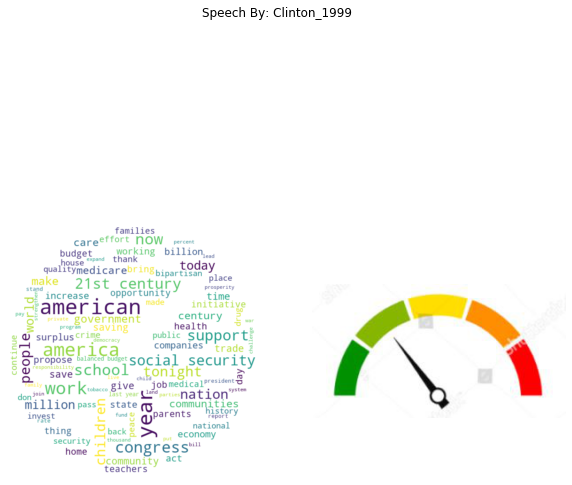

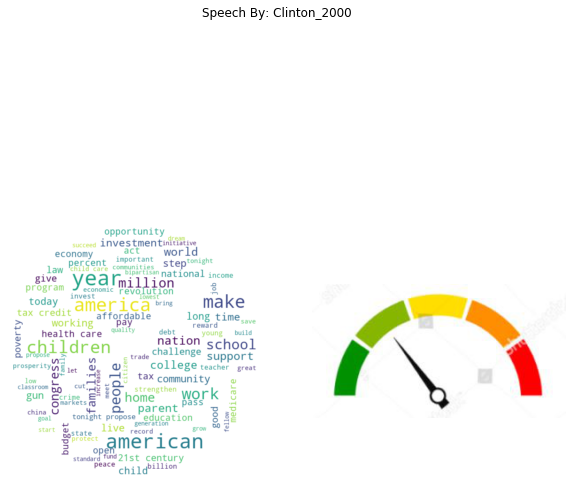

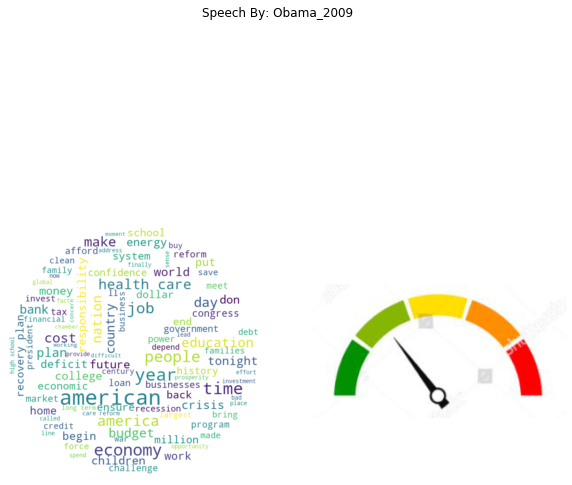

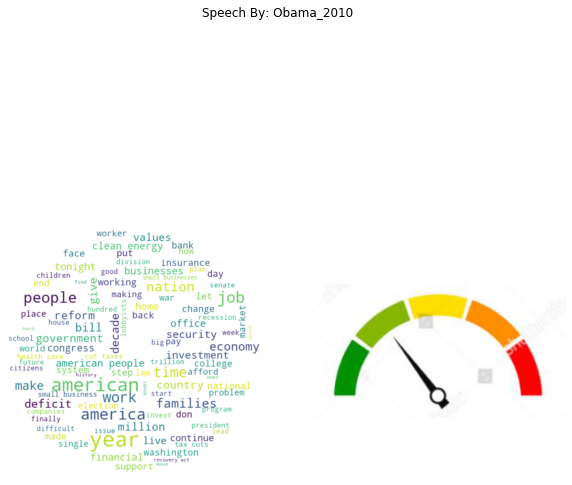

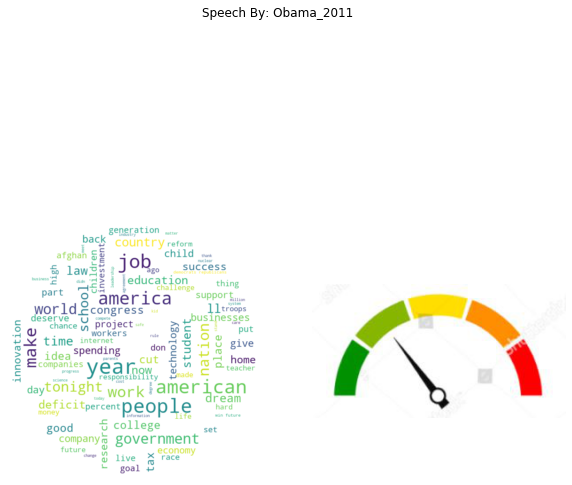

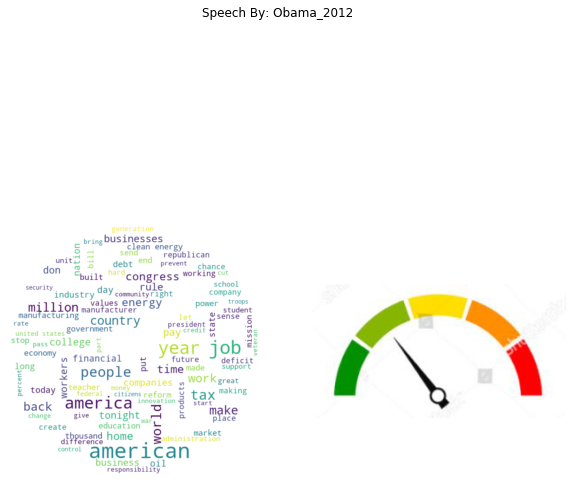

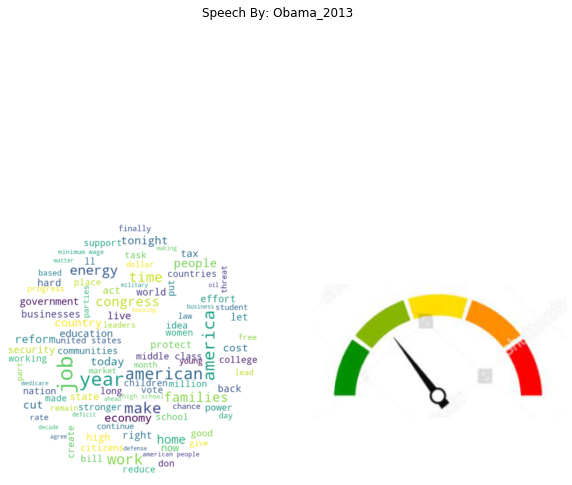

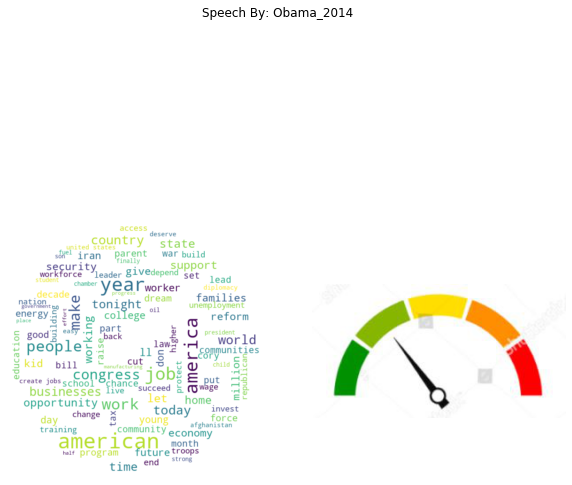

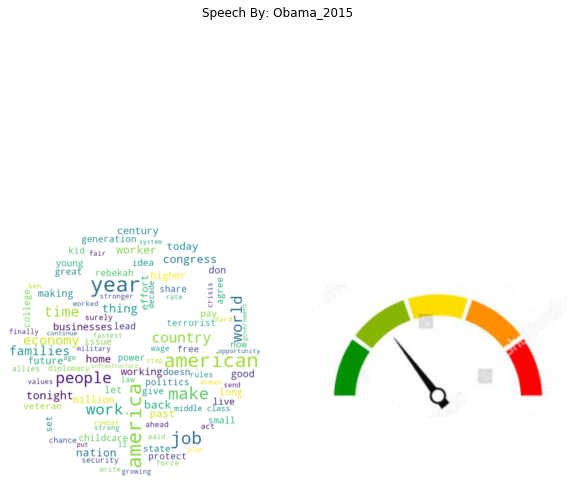

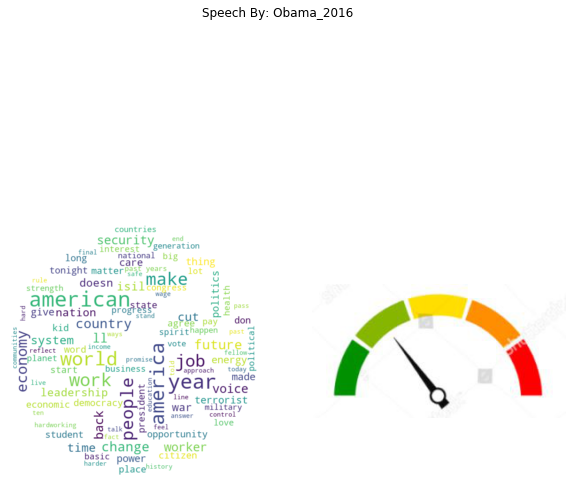

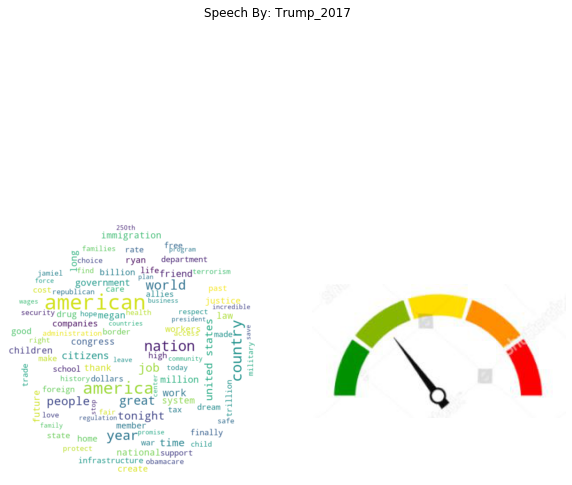

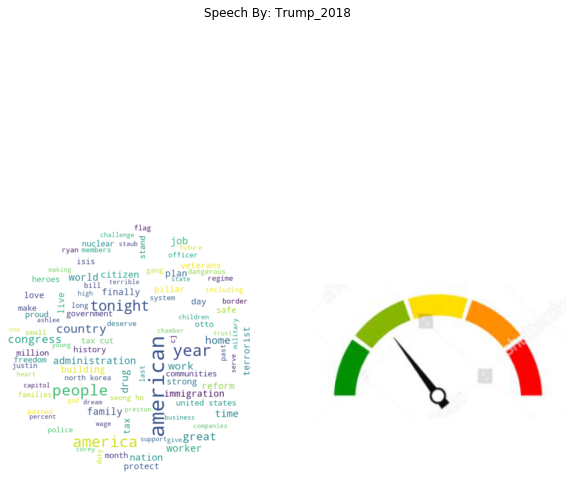

In [23]:
plt.rcParams["figure.figsize"] = (10,10)
for index, speech in enumerate(corpus_df_filtered['bow']):
    fig, axes = plt.subplots(1, 2)
    wc=WordCloud(max_font_size=50, max_words=100, background_color="white",width = 250, height = 250,  mask=mask)
    wordcloud =wc.generate(' '.join(speech))
    fig.suptitle("Speech By: "+(corpus_df_filtered.loc[index,'doc'].split('.')[0]))
    axes[0].imshow(wc, interpolation="bilinear")
    if corpus_df_filtered.loc[index,'pos']-corpus_df_filtered.loc[index,'neg']>0:
        axes[1].imshow(mask_pos, cmap=plt.cm.gray, interpolation="bilinear")
    elif corpus_df_filtered.loc[index,'pos']-corpus_df_filtered.loc[index,'neg']<0:
        axes[1].imshow(mask_neg, cmap=plt.cm.gray, interpolation="bilinear")
    else:
        axes[1].imshow(mask_neu, cmap=plt.cm.gray, interpolation="bilinear")
    for ax in axes:
        ax.set_axis_off()
    plt.show()

## POS tagging in NLTK

In [24]:
# Lab Week 4 - POS tagging in NLTK
# This file has small examples that are meant to be run individually
#   in the Python shell

import nltk

# POS Tagged Corpora:  Brown and Penn Treebank
# the Brown corpus has its own set of POS tags
from nltk.corpus import brown
# the tagged_sents function gives POS tagged sentences and tagged_words gives POS tagged words
print(brown.tagged_sents()[:2], '\n')
print(brown.tagged_words()[:50])


# Each tagged word is a pair, which Python calls a tuple  
#  it behaves like a list except that you can't change the elements (immutable)
wordtag = brown.tagged_words()[0]
print(wordtag)
print(type(wordtag))
print(wordtag[0])
print(wordtag[1])

# the brown corpus can also be accessed by category
print(brown.categories(), '\n')

brown_humor_tagged = brown.tagged_words(categories='humor', tagset='universal')
print(brown_humor_tagged[:50])

# the chat corpus uses Penn POS tags
print(nltk.corpus.nps_chat.tagged_words()[:50])

# Penn treebank
from nltk.corpus import treebank

# use corpus methods to get the text as strings and as tokens as before
treebank_text = treebank.raw()
print(treebank_text[:150], '\n')

treebank_tokens = treebank.words()
print(treebank_tokens[:20])

# but we also have functions to get words with tags and sentences with tagged words
treebank_tagged_words = treebank.tagged_words()
print(treebank_tagged_words[:50])

treebank_tagged = treebank.tagged_sents()
print(treebank_tagged[:2])


## Frequency distribution of tags in Penn Treebank
tag_fd = nltk.FreqDist(tag for (word, tag) in treebank_tagged_words)
print(tag_fd.keys(), '\n')

for tag,freq in tag_fd.most_common():
    print (tag, freq)

# use the first letter of the POS tag to get classes of tags
tag_classes_fd = nltk.FreqDist(tag[0] for (word, tag) in treebank_tagged_words)
print(tag_classes_fd.keys(), '\n')
for tag,freq in tag_classes_fd.most_common():
    print (tag, freq)


## POS Tagging

# Separating the data into training and test data
size = int(len(treebank_tagged) * 0.9)
treebank_train = treebank_tagged[:size]
treebank_test = treebank_tagged[size:]

# Default Tagger assign 'NN' to every word
# creates the tagger
t0 = nltk.DefaultTagger('NN')
# show the effect of the tagger by tagging the first 50 words
print(t0.tag(treebank_tokens[:50]))

# evaluate function applies the tagger t0 to the untagged version of treebank
#   and compares with the tagged version
print(t0.evaluate(treebank_test))

# Unigram tagger learns tag with the highest probability for each word
# creates the tagger on the training set
t1 = nltk.UnigramTagger(treebank_train)
# show the effect of the tagger by tagging the first 50 words
print(t1.tag(treebank_tokens[:50]))

# evaluates the tagger on the test set
print(t1.evaluate(treebank_test))

# Bigram Tagging with Backoff to Combine Taggers
# create a sequence of taggers with backoff to get a bigram tagger
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(treebank_train, backoff=t0)
t2 = nltk.BigramTagger(treebank_train, backoff=t1)
# Accuracy with BigramTagger: 
print(t2.evaluate(treebank_test))

# Using the bigram tagger on some new text
text = "Three Calgarians have found a rather unusual way of leaving snow and ice behind. They set off this week on foot and by camels on a grueling trek across the burning Arabian desert."

# Unigram tagger learns tag with the highest probability for each word
# creates the tagger on the training set
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(treebank_tagged)
# show the effect of the tagger by tagging the first 50 words
print(t1.tag(treebank_tokens[:50]))

# evaluates the tagger on the test set
print(t1.evaluate(treebank_test))

# Bigram Tagging with Backoff to Combine Taggers
# create a sequence of taggers with backoff to get a bigram tagger
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(treebank_tagged, backoff=t0)
t2 = nltk.BigramTagger(treebank_tagged, backoff=t1)

# Accuracy with BigramTagger: 
print(t2.evaluate(treebank_test))

# But we should separate the text into sentences first
textsplit = nltk.sent_tokenize(text)
print(textsplit)

# apply the word tokenizer to each sentence
tokentext = [nltk.word_tokenize(sent) for sent in textsplit]
print(tokentext)

# use the t2 bigram tagger to tag each sentence tokens
taggedtext = [t2.tag(tokens) for tokens in tokentext]
print(taggedtext)


# use the Stanford POS tagger to tag each sentence tokens
taggedtextStanford = [nltk.pos_tag(tokens) for tokens in tokentext]
print(taggedtextStanford)

# show how to flatten a list of tagged tokens
taggedtext_flat = [pair for sent in taggedtext for pair in sent]
print(taggedtext_flat)

taggedtextStanford_flat = [pair for sent in taggedtextStanford for pair in sent]
print(taggedtextStanford_flat)


[[('The', 'AT'), ('Fulton', 'NP-TL'), ('County', 'NN-TL'), ('Grand', 'JJ-TL'), ('Jury', 'NN-TL'), ('said', 'VBD'), ('Friday', 'NR'), ('an', 'AT'), ('investigation', 'NN'), ('of', 'IN'), ("Atlanta's", 'NP$'), ('recent', 'JJ'), ('primary', 'NN'), ('election', 'NN'), ('produced', 'VBD'), ('``', '``'), ('no', 'AT'), ('evidence', 'NN'), ("''", "''"), ('that', 'CS'), ('any', 'DTI'), ('irregularities', 'NNS'), ('took', 'VBD'), ('place', 'NN'), ('.', '.')], [('The', 'AT'), ('jury', 'NN'), ('further', 'RBR'), ('said', 'VBD'), ('in', 'IN'), ('term-end', 'NN'), ('presentments', 'NNS'), ('that', 'CS'), ('the', 'AT'), ('City', 'NN-TL'), ('Executive', 'JJ-TL'), ('Committee', 'NN-TL'), (',', ','), ('which', 'WDT'), ('had', 'HVD'), ('over-all', 'JJ'), ('charge', 'NN'), ('of', 'IN'), ('the', 'AT'), ('election', 'NN'), (',', ','), ('``', '``'), ('deserves', 'VBZ'), ('the', 'AT'), ('praise', 'NN'), ('and', 'CC'), ('thanks', 'NNS'), ('of', 'IN'), ('the', 'AT'), ('City', 'NN-TL'), ('of', 'IN-TL'), ('Atlant

0.8905852417302799
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.'), ('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'JJ'), ('publishing', 'NN'), ('group', 'NN'), ('.', '.'), ('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT')]
0.96
0.9863613231552163
['Three Calgarians have found a rather unusual way of leaving snow and ice behind.', 'They set off this week on foot and by camels on

In [29]:
corpus_df_filtered['treebank_tag']=corpus_df_filtered['bow'].apply(lambda x: list(t2.tag(x)))
corpus_df_filtered['pos_tag']=corpus_df_filtered['bow'].apply(lambda x: list(nltk.pos_tag(x)))

In [31]:
corpus_df_filtered.loc[0,'treebank_tag']

[('mr', 'NN'),
 ('speaker', 'NN'),
 ('mr', 'NN'),
 ('president', 'NN'),
 ('distinguished', 'VBD'),
 ('members', 'NNS'),
 ('house', 'NN'),
 ('senate', 'NN'),
 ('honored', 'NN'),
 ('guests', 'NNS'),
 ('fellow', 'JJ'),
 ('citizens', 'NNS'),
 ('less', 'JJR'),
 ('3', 'CD'),
 ('weeks', 'NNS'),
 ('ago', 'IN'),
 ('i', 'NN'),
 ('joined', 'VBD'),
 ('west', 'NN'),
 ('front', 'NN'),
 ('building', 'NN'),
 ('monuments', 'NN'),
 ('proud', 'NN'),
 ('past', 'JJ'),
 ('offered', 'VBD'),
 ('hand', 'NN'),
 ('filling', 'VBG'),
 ('page', 'NN'),
 ('american', 'NN'),
 ('history', 'NN'),
 ('story', 'NN'),
 ('extended', 'VBD'),
 ('prosperity', 'NN'),
 ('continued', 'VBD'),
 ('peace', 'NN'),
 ('and', 'CC'),
 ('tonight', 'NN'),
 ('i', 'NN'),
 ('back', 'RB'),
 ('offer', 'VB'),
 ('plans', 'NNS'),
 ('the', 'DT'),
 ('hand', 'NN'),
 ('remains', 'VBZ'),
 ('extended', 'VBD'),
 ('sleeves', 'NN'),
 ('rolled', 'VBN'),
 ('america', 'NN'),
 ('waiting', 'VBG'),
 ('produce', 'VB'),
 ('together', 'RB'),
 ('build', 'VB'),
 ('amer

In [32]:
corpus_df_filtered.loc[0,'pos_tag']

[('mr', 'NN'),
 ('speaker', 'NN'),
 ('mr', 'FW'),
 ('president', 'NN'),
 ('distinguished', 'VBD'),
 ('members', 'NNS'),
 ('house', 'NN'),
 ('senate', 'NN'),
 ('honored', 'VBD'),
 ('guests', 'NNS'),
 ('fellow', 'JJ'),
 ('citizens', 'NNS'),
 ('less', 'CC'),
 ('3', 'CD'),
 ('weeks', 'NNS'),
 ('ago', 'RB'),
 ('i', 'VBP'),
 ('joined', 'VBD'),
 ('west', 'JJS'),
 ('front', 'JJ'),
 ('building', 'NN'),
 ('monuments', 'NNS'),
 ('proud', 'JJ'),
 ('past', 'NN'),
 ('offered', 'VBD'),
 ('hand', 'NN'),
 ('filling', 'VBG'),
 ('page', 'JJ'),
 ('american', 'JJ'),
 ('history', 'NN'),
 ('story', 'NN'),
 ('extended', 'VBN'),
 ('prosperity', 'NN'),
 ('continued', 'VBD'),
 ('peace', 'NN'),
 ('and', 'CC'),
 ('tonight', 'NN'),
 ('i', 'NN'),
 ('back', 'RB'),
 ('offer', 'NN'),
 ('plans', 'VBZ'),
 ('the', 'DT'),
 ('hand', 'NN'),
 ('remains', 'VBZ'),
 ('extended', 'JJ'),
 ('sleeves', 'NNS'),
 ('rolled', 'VBD'),
 ('america', 'RP'),
 ('waiting', 'VBG'),
 ('produce', 'NN'),
 ('together', 'RB'),
 ('build', 'VB'),
 ('a

In [36]:
## Frequency distribution of tags in Penn Treebank
tag_fd = nltk.FreqDist(tag for (word, tag) in [item for sublist in list(corpus_df_filtered['treebank_tag']) for item in sublist])
print(tag_fd.keys(), '\n')

for tag,freq in tag_fd.most_common():
    print (tag, freq)

# use the first letter of the POS tag to get classes of tags
tag_classes_fd = nltk.FreqDist(tag[0] for (word, tag) in  [item for sublist in list(corpus_df_filtered['pos_tag']) for item in sublist])
print(tag_classes_fd.keys(), '\n')
for tag,freq in tag_classes_fd.most_common():
    print (tag, freq)

dict_keys(['NN', 'VBD', 'NNS', 'JJ', 'JJR', 'CD', 'IN', 'VBG', 'CC', 'RB', 'VB', 'DT', 'VBZ', 'VBN', 'PRP', 'VBP', 'PRP$', 'WDT', 'WRB', 'JJS', 'RBR', 'EX', '``', 'TO', '.', ':', 'WP', 'RP', 'FW', 'MD', 'LS', 'RBS', 'NNP', 'PDT']) 

NN 46539
NNS 10539
JJ 7006
VB 5254
VBG 2127
VBD 1914
VBN 1889
PRP 1814
RB 1785
VBP 1722
CD 1542
CC 1494
IN 1484
DT 1178
VBZ 1021
JJR 527
PRP$ 398
JJS 246
WDT 219
TO 140
WRB 108
. 90
WP 39
: 26
RBR 24
RP 21
MD 20
EX 13
NNP 10
RBS 5
LS 4
`` 3
FW 3
PDT 1
dict_keys(['N', 'F', 'V', 'J', 'C', 'R', 'D', 'P', 'I', 'E', 'W', '`', 'T', '.', ':', 'M', 'U', '$', '(']) 

N 44005
V 17652
J 15362
C 3419
R 2862
P 2223
I 1872
D 1160
W 262
T 140
. 90
E 46
F 35
: 26
M 25
$ 17
( 4
` 3
U 2
